# Shell View
The goal of this notebook is to view the fragments of a system as a sort of "shell structure". The basic hypothesis is as follows. Each fragment in a system is surrounded by other fragments, which exist at different distances. The closer two fragments are to each other, the greater the deviation from purity caused by their overlap. We expect to see a decay in overlap as the distance increases.

To run this notebook, you need the files `density_kernel_sparse.mtx` and `hamiltonian_sparse.mtx`. Once you have obtained those files, place them in the `Matrices` folder.

## Generate Overlap
The first step will involve building a matrix which represents the fragment overlaps. First, we need to define the parameters for this calculation.

In [1]:
density_file = "Matrices/density_kernel_sparse.mtx"
hamiltonian_file = "Matrices/hamiltonian_sparse.mtx"
metadata_file = "Matrices/sparsematrix_metadata.dat"
geom_file = "Geometry/Single/1L2Y.yaml"
image_size = (10,6)

### Compute The Rows of the Matrix Associated With Each Atom

CheSS's `get_atomic_lookup` routine gives us the information we need. For it gives us a list of size number of basis functions, and each entry describes which atom that basis function is on.

In [2]:
from CheSS import Matrices as M

In [3]:
alookup = M.get_atomic_lookup(metadata_file)
nbf = len(alookup)

### Compute The Rows of the Matrix Associated with Each Fragment

Here the routines we need are provided by PyBigDFT. First, we create a dictionary which associates atoms with each fragment. Then we create a reverse lookup from atoms to fragments, and finally a reverse lookup from basis functions to fragments.

In [4]:
from BigDFT import Fragments as F

In [5]:
from yaml import load
with open(geom_file) as ifile:
    sys = load(ifile)
    positions = sys["Reading positions"].itervalues().next()
fdict = F.CreateFragDict(positions)

In [6]:
from numpy import zeros
fcounter = 0
natoms = len(positions["positions"])
atom_to_fragment = zeros(natoms)
frag_classifier = []
for fname in fdict.keys():
    for fid in fdict[fname].keys():
        for atoms in fdict[fname][fid]:
            atom_to_fragment[atoms-1] = fcounter
        fcounter += 1
        frag_classifier.append(fname)
atom_to_fragment = [int(x) for x in atom_to_fragment]
nfrags = fcounter

In [7]:
basis_to_fragment = []
for i in range(0, len(alookup)):
    basis_to_fragment.append(atom_to_fragment[alookup[i]])

## Generate The Shell Structure
As a bit of a detour, we need to know the distance between each fragment. 

In [8]:
def distance(i,j, cell=None):
    "Distance between fragments, defined as distance between center of mass"
    import numpy
    vec=i.centroid()-j.centroid()
    if cell:
        for i, p in enumerate(cell):
            vec[i] -= cell[i]*int(round(vec[i]/cell[i]))
    return numpy.sqrt(numpy.dot(vec,vec.T))


system = F.System(posinp_dict=positions)
sys_cell = sys["Reading positions"].itervalues().next()["cell"]
distance_matrix = zeros((nfrags,nfrags))
for i, f1 in enumerate(system.fragments):
    for j, f2 in enumerate(system.fragments):
        val = distance(f1, f2, cell=sys_cell)
        distance_matrix[i,j] = val

### Indexing Help
For each basis function, it has already an associated fragment. It also needs to have an inner index, which orders it amongst different basis functions in the same fragment.

## Fragment Matrix
We will now turn to the actual matrices. We want to generate a fragment x fragment matrix, where each entry represents the norm of the blocks in the full matrix.

In [9]:
from numpy import cumsum
inner_index = []
offsets = zeros(nfrags)
for i in range(0, nbf):
    frag = basis_to_fragment[i]
    inner_index.append(int(offsets[frag]))
    offsets[frag] += 1
cum_offsets = [0] + [int(x) for x in cumsum(offsets)]

### Matrix of Norms
Now to actually compute that matrix. First we reorder the matrix according to the fragment blocking.

In [10]:
from scipy.io import mmread
matrix = []
matrix.append(mmread(hamiltonian_file).todense())
matrix.append(mmread(density_file).todense())

In [11]:
reordered_matrix = []
for mat in matrix:
    re_matrix = zeros((nbf,nbf))
    for j in range(0, nbf):
        frag_j = basis_to_fragment[j]
        new_j = cum_offsets[frag_j] + inner_index[j]
        for i in range(0, nbf):
            frag_i = basis_to_fragment[i]
            new_i = cum_offsets[frag_i] + inner_index[i]
            re_matrix[new_i,new_j] = mat[i,j]
    reordered_matrix.append(re_matrix)

Now for the frag matrix.

In [12]:
from numpy.linalg import norm
block_matrix = []
for mat in reordered_matrix:
    bmat = zeros((nfrags,nfrags))
    for frag_j in range(0, nfrags):
        start_j = cum_offsets[frag_j]
        end_j = cum_offsets[frag_j+1]
        for frag_i in range(0, nfrags):
            start_i = cum_offsets[frag_i]
            end_i = cum_offsets[frag_i+1]
            submat = mat[start_i:end_i, start_j:end_j]
            bmat[frag_i,frag_j] = norm(submat)
    bmat /= norm(bmat)
    block_matrix.append(bmat)

## Visualize
Now we're ready to visualize the results. First, let's take a look at the block matrix. Note that these values are normalized so that the highest value is 1.0.

In [13]:
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from numpy import amax

viznorm = LogNorm(vmin=1e-7, vmax=1.0)

fig, axs = plt.subplots(1,3,figsize=image_size)
im = []
im.append(axs[0].imshow(distance_matrix))
im.append(axs[1].imshow(block_matrix[0], norm=viznorm))
im.append(axs[2].imshow(block_matrix[1], norm=viznorm))

cbaxes = fig.add_axes([0.2, 0.2, 0.6, 0.03]) 
cb = plt.colorbar(im[2], cax = cbaxes, orientation='horizontal')
cb.set_label("Norm Value")

cbaxes = fig.add_axes([0.2, 0.83, 0.6, 0.03]) 
cb = plt.colorbar(im[0], cax = cbaxes, orientation='horizontal')
cb.set_label("Distance")

axs[0].set_title("Distance")
axs[1].set_title("Hamiltonian")
axs[2].set_title("Density")

This is probably not so useful on its on. So next, what we want to do is show the correlation between distance and norm value. We can plot this fairly easily.

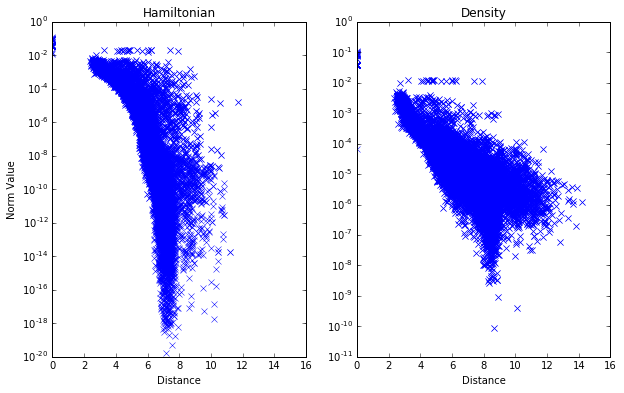

In [14]:
fig, axs = plt.subplots(1,2,figsize=image_size)  
xvalues = [[],[]]
yvalues = [[],[]]
for j in range(0, len(matrix)):
    for frag_i in range(0, nfrags):
        for frag_j in range(0, nfrags):
            xvalues[j].append(distance_matrix[frag_i,frag_j])
            yvalues[j].append(block_matrix[j][frag_i,frag_j])
    axs[j].plot(xvalues[j], yvalues[j], 'x')
    axs[j].set_yscale("log")
    axs[j].set_xlim(0,16)
axs[0].set_title("Hamiltonian")
axs[1].set_title("Density")
axs[0].set_ylabel("Norm Value")
axs[0].set_xlabel("Distance")
axs[1].set_xlabel("Distance")

Lets classify these values

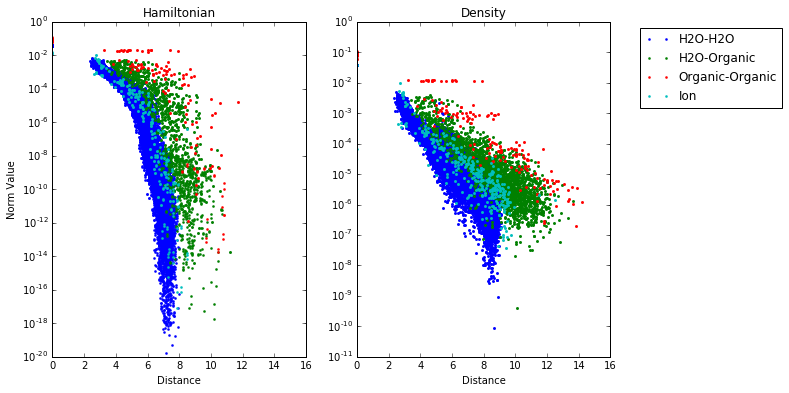

In [15]:
fig, axs = plt.subplots(1,2,figsize=image_size)
h2oh2o_xvalues = [[],[]]
h2oh2o_yvalues = [[],[]]
ion_xvalues = [[],[]]
ion_yvalues = [[],[]]
h2oother_xvalues = [[],[]]
h2oother_yvalues = [[],[]]
otherother_xvalues = [[],[]]
otherother_yvalues = [[],[]]
for j in range(0, len(matrix)):
    for frag_i in range(0, nfrags):
        for frag_j in range(0, nfrags):
            xvalues[j].append(distance_matrix[frag_i,frag_j])
            yvalues[j].append(block_matrix[j][frag_i,frag_j])
            if frag_classifier[frag_i] == "WAT" and frag_classifier[frag_j] == "WAT":
                h2oh2o_xvalues[j].append(distance_matrix[frag_i,frag_j])
                h2oh2o_yvalues[j].append(block_matrix[j][frag_i,frag_j])
            elif frag_classifier[frag_i] == "SOD" or frag_classifier[frag_j] == "SOD" or \
                 frag_classifier[frag_i] == "CLA" or frag_classifier[frag_j] == "CLA":
                ion_xvalues[j].append(distance_matrix[frag_i,frag_j])
                ion_yvalues[j].append(block_matrix[j][frag_i,frag_j])
            elif frag_classifier[frag_i] == "WAT" or frag_classifier[frag_j] == "WAT":
                h2oother_xvalues[j].append(distance_matrix[frag_i,frag_j])
                h2oother_yvalues[j].append(block_matrix[j][frag_i,frag_j])
            else:
                otherother_xvalues[j].append(distance_matrix[frag_i,frag_j])
                otherother_yvalues[j].append(block_matrix[j][frag_i,frag_j])
    axs[j].plot(h2oh2o_xvalues[j], h2oh2o_yvalues[j], '.', markersize=4, label="H2O-H2O")
    axs[j].plot(h2oother_xvalues[j], h2oother_yvalues[j], '.', markersize=4, label="H2O-Organic")
    axs[j].plot(otherother_xvalues[j], otherother_yvalues[j], '.', markersize=4, label="Organic-Organic")
    axs[j].plot(ion_xvalues[j], ion_yvalues[j], '.', markersize=4, label="Ion")
    axs[j].set_yscale("log")
    axs[j].set_xlim(0,16)
axs[0].set_title("Hamiltonian")
axs[1].set_title("Density")
axs[0].set_ylabel("Norm Value")
axs[0].set_xlabel("Distance")
axs[1].set_xlabel("Distance")
plt.legend(bbox_to_anchor=(1.7,1), ncol=1)

And the correlation between the two matrices.

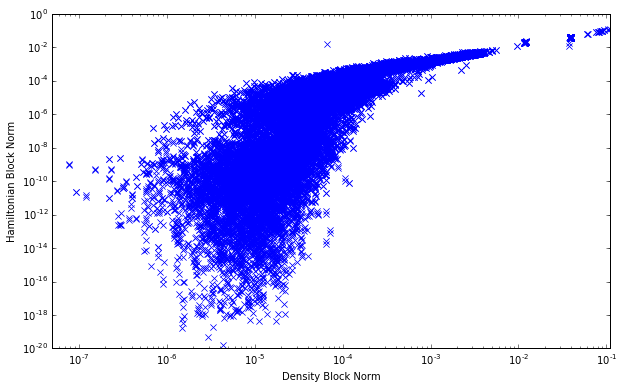

In [16]:
fig, axs = plt.subplots(1,1,figsize=image_size)
axs.plot(yvalues[1],yvalues[0], 'x')
axs.set_xscale("log")
axs.set_xlim(5e-8, max(yvalues[1]))
axs.set_yscale("log")
axs.set_ylabel("Hamiltonian Block Norm")
axs.set_xlabel("Density Block Norm")

### Clustered Visualization

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


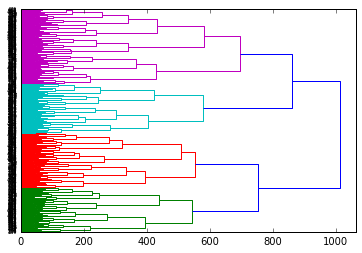

In [17]:
import scipy.cluster.hierarchy as sch
Y = sch.linkage(distance_matrix, method='ward')
Z = sch.dendrogram(Y, orientation='right')
index = Z['leaves']
D2 = distance_matrix[index,:]
D2 = D2[:,index]
clustered_mat = []
for j in range(0,2):
    bmat = block_matrix[j][index,:]
    bmat = bmat[:,index]
    clustered_mat.append(bmat)

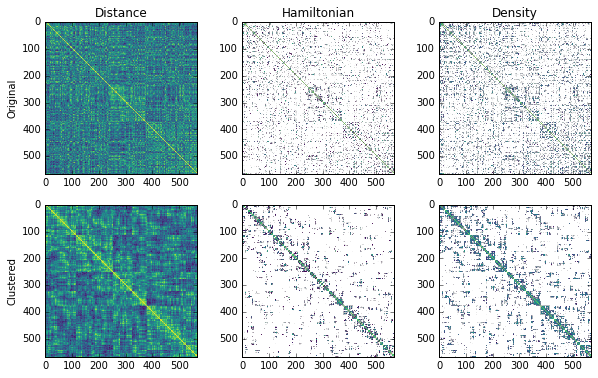

In [19]:
fig, axs = plt.subplots(2,3,figsize=image_size)
colorchoice="viridis"
im = []
im.append(axs[0,0].imshow(distance_matrix, cmap=colorchoice+"_r"))
im.append(axs[0,1].imshow(block_matrix[0], norm=viznorm, cmap=colorchoice))
im.append(axs[0,2].imshow(block_matrix[1], norm=viznorm, cmap=colorchoice))
im.append(axs[1,0].imshow(D2, cmap=colorchoice+"_r"))
im.append(axs[1,1].imshow(clustered_mat[0], norm=viznorm, cmap=colorchoice))
im.append(axs[1,2].imshow(clustered_mat[1], norm=viznorm, cmap=colorchoice))

axs[0,0].set_title("Distance")
axs[0,1].set_title("Hamiltonian")
axs[0,2].set_title("Density")
axs[0,0].set_ylabel("Original")
axs[1,0].set_ylabel("Clustered")